In [1]:
# Load the cleaned data

import pandas as pd

reviews = pd.read_csv('../data/cleaned_reviews.csv', parse_dates=["date"])

# Drop rows with missing values

reviews.dropna(inplace=True)

In [33]:
reviews.shape
print(reviews.head())

# Data types
print(reviews.dtypes)

# Info
print(reviews.info())

# Describe summary statistics
print(reviews.describe())

#Check for missing values
print(reviews.isna().sum())

                                              review  rating bank  \
0                         So bad now and hard to use       5  CBE   
1  it is so amazing app. but, it is better to upd...       5  CBE   
2                                         v.good app       4  CBE   
3                                      very good app       1  CBE   
4           Very amazing app indeed. I'm enjoying it       5  CBE   

        source       date                                   processed_review  \
0  Google Play 2025-06-09                                       bad hard use   
1  Google Play 2025-06-09  amazing app better update access without inter...   
2  Google Play 2025-06-09                                                app   
3  Google Play 2025-06-09                                           good app   
4  Google Play 2025-06-08                        amazing app indeed enjoying   

   sentiment_score vader_sentiment textblob_sentiment distilBert_sentiment  \
0          -0.5994        

In [4]:
# Sentiment analysis using Vader

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Define a function to label sentiment
def get_vader_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        label = 'positive'
    elif score <= -0.05:
        label = 'negative'
    else:
        label = 'neutral'
    return pd.Series([score, label])  

# Apply to each review
reviews[['sentiment_score', 'vader_sentiment']] = reviews['processed_review'].apply(get_vader_sentiment)

# Display sentiment distribution
print(reviews.groupby('bank')['vader_sentiment'].value_counts())

bank    vader_sentiment
BOA     positive           156
        neutral            128
        negative           114
CBE     positive           243
        neutral            106
        negative            37
Dashen  positive           285
        neutral             76
        negative            19
Name: count, dtype: int64


In [5]:
# Sentiment analysis using TextBlob

from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis
reviews['textblob_sentiment'] = reviews['processed_review'].apply(get_sentiment)

# Display sentiment distribution
print(reviews.groupby('bank')['textblob_sentiment'].value_counts())

bank    textblob_sentiment
BOA     positive              159
        neutral               136
        negative              103
CBE     positive              238
        neutral               120
        negative               28
Dashen  positive              281
        neutral                72
        negative               27
Name: count, dtype: int64


In [6]:
# Sentiment analysis using DistilBert

import torch
from transformers import pipeline


# Load the sentiment analysis pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    framework="pt"
)

# Function to get sentiment
def get_sentiment_label(text):
    result = sentiment_pipeline(text[:512])[0]
    return result['label'].lower()

# Apply to DataFrame
reviews['distilBert_sentiment'] = reviews['review'].apply(get_sentiment_label)

# Save
#df.to_csv('reviews_with_distilbert_sentiment.csv', index=False)
print("Sentiment analysis complete with DistilBERT.")
print(reviews.groupby('bank')['distilBert_sentiment'].value_counts())

c:\Users\mike\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


Sentiment analysis complete with DistilBERT.
bank    distilBert_sentiment
BOA     negative                274
        positive                124
CBE     positive                240
        negative                146
Dashen  positive                281
        negative                 99
Name: count, dtype: int64


In [7]:
# Keyword Extraction with TF-Ireviews

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt
from wordcloud import WordCloud


# Your extra stop words
extra_stop_words = ['cbe', 'boa', 'dashen', 'app', 'application', 'apes', 'bank', 'also', 'ca', 'ethiopia', 'even', 'ever', 'every', 'everything', 'get', 'use', 'used', 'using', 'know', 'one']

# Combine with default English stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(extra_stop_words))

# Initialize TF-IDF Vectorizer with your custom stop words
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=50)

# Fit and transform your review text
tfidf_matrix = vectorizer.fit_transform(reviews['processed_review'])

# Get the cleaned list of keywords
keywords = vectorizer.get_feature_names_out()
print("Top keywords:", keywords)


Top keywords: ['account' 'ahead' 'amazing' 'banking' 'best' 'better' 'convenient'
 'crash' 'customer' 'developer' 'digital' 'easy' 'excellent' 'experience'
 'fast' 'feature' 'fix' 'good' 'great' 'issue' 'like' 'love' 'make'
 'mobile' 'money' 'need' 'nice' 'option' 'payment' 'phone' 'really'
 'reliable' 'screenshot' 'secure' 'service' 'slow' 'smooth' 'step' 'super'
 'thank' 'time' 'transaction' 'transfer' 'try' 'update' 'user' 'work'
 'working' 'worst' 'wow']


In [11]:
# Filter positive and negative reviews
positive_reviews = reviews[reviews['distilBert_sentiment'] == 'positive']['processed_review']
negative_reviews = reviews[reviews['distilBert_sentiment'] == 'negative']['processed_review']

# Extract keywords from positive reviews
vectorizer_pos = TfidfVectorizer(stop_words=stop_words, max_features=10)
X_pos = vectorizer_pos.fit_transform(positive_reviews)
print("Top Keywords in Positive Reviews:", vectorizer_pos.get_feature_names_out())

# Extract keywords from negative reviews
vectorizer_neg = TfidfVectorizer(stop_words=stop_words, max_features=10)
X_neg = vectorizer_neg.fit_transform(negative_reviews)
print("Top Keywords in Negative Reviews:", vectorizer_neg.get_feature_names_out())

KeyError: 'distilBert_sentiment'

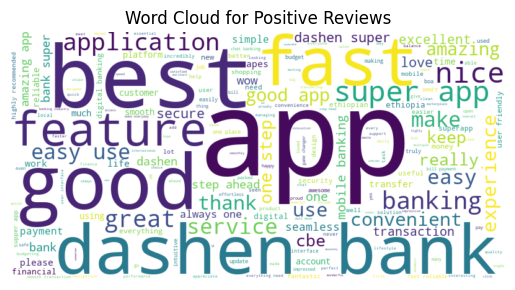

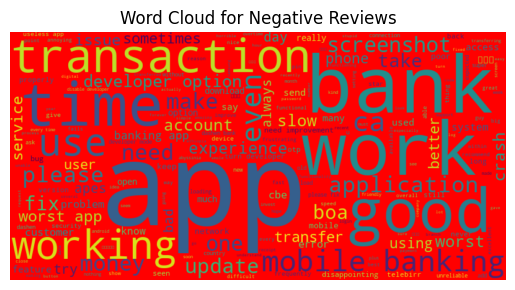

In [ ]:
# General WordCloud visuals

# Word cloud for positive reviews
positive_text = ' '.join(positive_reviews)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

negative_text = ' '.join(negative_reviews)
wordcloud = WordCloud(width=800, height=400, background_color='red').generate(negative_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

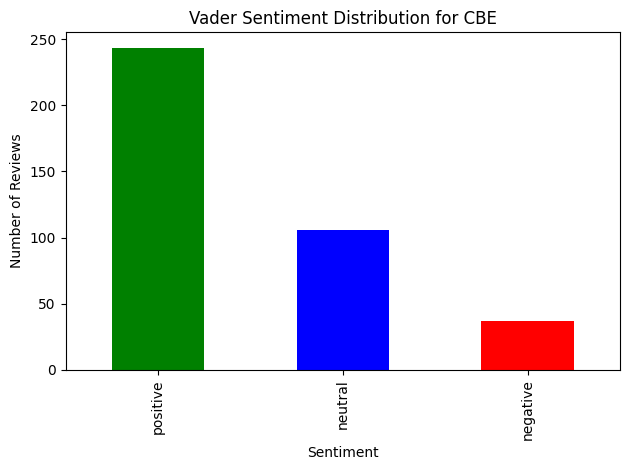

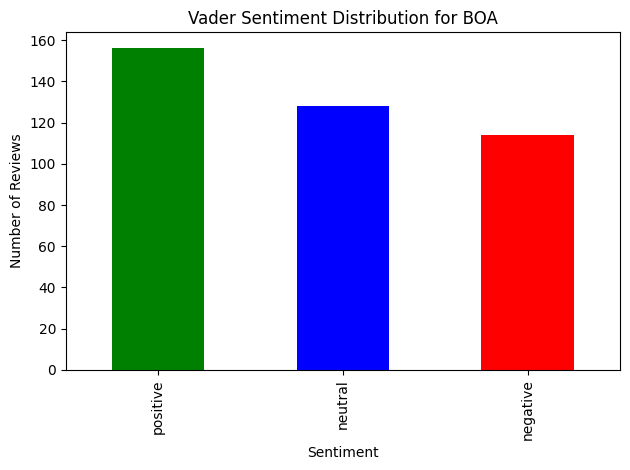

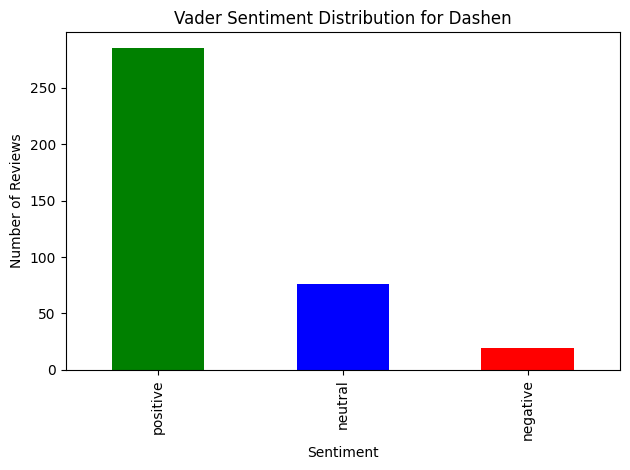

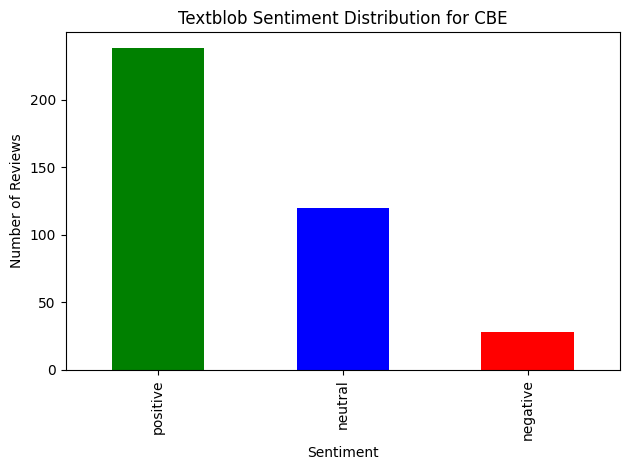

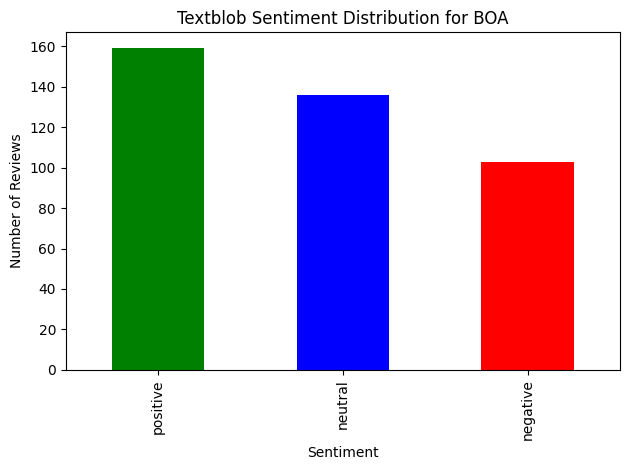

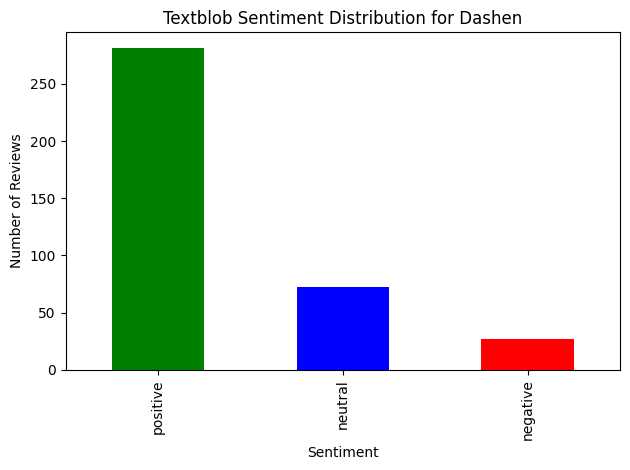

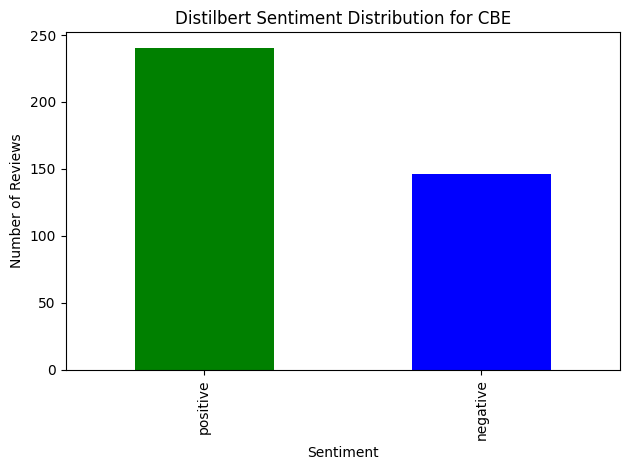

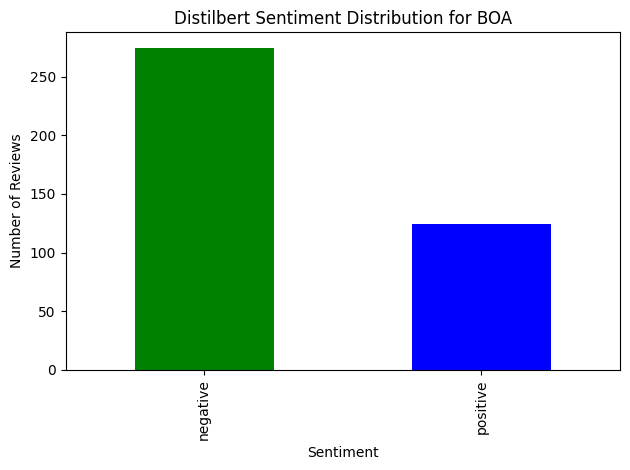

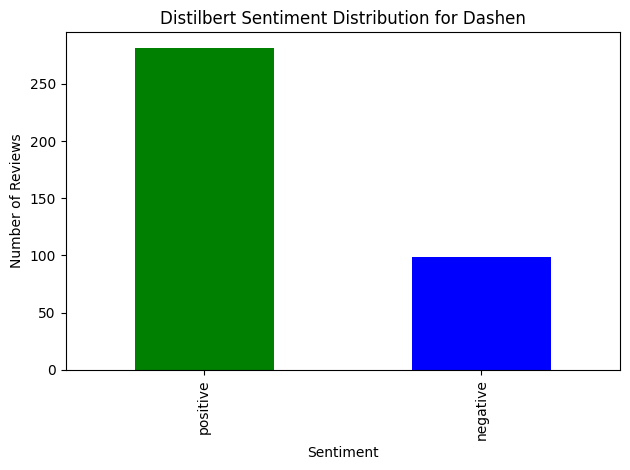

In [27]:
# Plotting the sentiment reviews for each bank
import matplotlib.pyplot as plt

banks = ['CBE', 'BOA', 'Dashen']

# Plot for Vader sentiment

for bank in banks:
    data = reviews[reviews['bank'] == bank]['vader_sentiment'].value_counts()
    data.plot(kind='bar', title=f'Vader Sentiment Distribution for {bank}', color=['green', 'blue', 'red'])
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Reviews')
    plt.tight_layout()
    plt.show()


# Plot for Textblob sentiment

for bank in banks:
    data = reviews[reviews['bank'] == bank]['textblob_sentiment'].value_counts()
    data.plot(kind='bar', title=f'Textblob Sentiment Distribution for {bank}', color=['green', 'blue', 'red'])
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Reviews')
    plt.tight_layout()
    plt.show()


# Plot for Distilbert sentiment

for bank in banks:
    data = reviews[reviews['bank'] == bank]['distilBert_sentiment'].value_counts()
    data.plot(kind='bar', title=f'Distilbert Sentiment Distribution for {bank}', color=['green', 'blue', 'red'])
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Reviews')
    plt.tight_layout()
    plt.show()


In [10]:
# Keyword analysis for each bank

from sklearn.feature_extraction.text import TfidfVectorizer

# Filtering bank reviews

cbe_reviews = reviews[reviews['bank'] == 'CBE']
boa_reviews = reviews[reviews['bank'] == 'BOA']
dashen_reviews = reviews[reviews['bank'] == 'Dashen']


banks = ['CBE', 'BOA', 'Dashen']

# Create a dictionary to save the keywords for each bank 

top_keywords_per_bank = {}


for bank in banks:
    # Filter reviews
    bank_reviews = reviews[reviews['bank'] == bank]['review'].dropna().tolist()

    # Initialize TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=20)  # top 20 keywords
    tfidf_matrix = vectorizer.fit_transform(bank_reviews)

    # Get top keywords
    keywords = vectorizer.get_feature_names_out()
    
    print(f"\n🔹 Top keywords for {bank}:")
    print(keywords)

    top_keywords_per_bank[bank] = keywords.tolist()


print("\nTop keywords by bank:")
print(top_keywords_per_bank)



🔹 Top keywords for CBE:
['account' 'amazing' 'apps' 'banking' 'best' 'don' 'easy' 'fast' 'good'
 'great' 'like' 'make' 'mobile' 'money' 'need' 'nice' 'screenshot'
 'update' 'work' 'ነው']

🔹 Top keywords for BOA:
['banking' 'best' 'better' 'crashes' 'developer' 'doesn' 'don' 'fix'
 'good' 'like' 'make' 'mobile' 'money' 'open' 'service' 'slow' 'time'
 'work' 'working' 'worst']

🔹 Top keywords for Dashen:
['ahead' 'amazing' 'banking' 'best' 'convenient' 'digital' 'easy'
 'experience' 'fast' 'features' 'friendly' 'good' 'like' 'mobile' 'secure'
 'smooth' 'step' 'super' 'transactions' 'user']

Top keywords by bank:
{'CBE': ['account', 'amazing', 'apps', 'banking', 'best', 'don', 'easy', 'fast', 'good', 'great', 'like', 'make', 'mobile', 'money', 'need', 'nice', 'screenshot', 'update', 'work', 'ነው'], 'BOA': ['banking', 'best', 'better', 'crashes', 'developer', 'doesn', 'don', 'fix', 'good', 'like', 'make', 'mobile', 'money', 'open', 'service', 'slow', 'time', 'work', 'working', 'worst'], 'Da


🔹 Processing CBE...
Number of reviews: 386

🔹 Topic 0:
['good', 'like', 'make', 'easy', 'fast', 'transaction', 'transfer', 'really', 'need', 'screenshot']

🔹 Topic 1:
['best', 'banking', 'mobile', 'amazing', 'service', 'network', 'issue', 'wow', 'thank', 'bad']

🔹 Topic 2:
['nice', 'great', 'work', 'screenshot', 'money', 'excellent', 'developer', 'option', 'fix', 'problem']


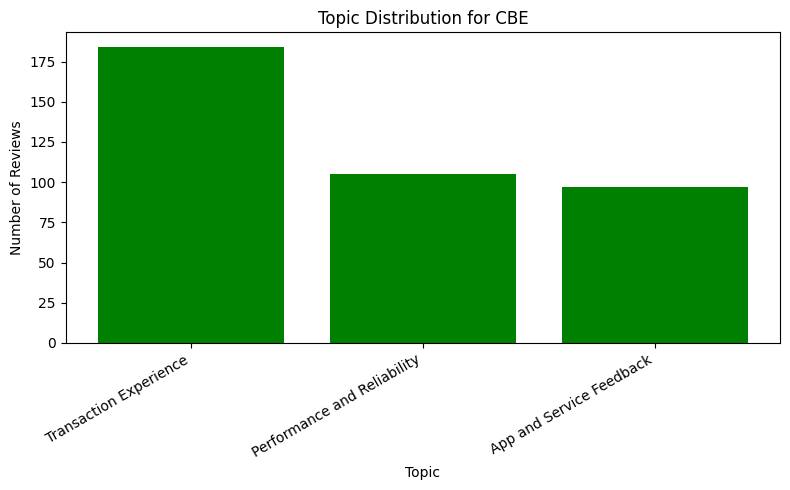


🔹 Processing BOA...
Number of reviews: 398

🔹 Topic 0:
['good', 'working', 'developer', 'banking', 'option', 'mobile', 'worst', 'money', 'poor', 'make']

🔹 Topic 1:
['worst', 'banking', 'mobile', 'time', 'service', 'transaction', 'nice', 'work', 'bad', 'experience']

🔹 Topic 2:
['work', 'like', 'developer', 'update', 'option', 'best', 'time', 'android', 'fix', 'phone']


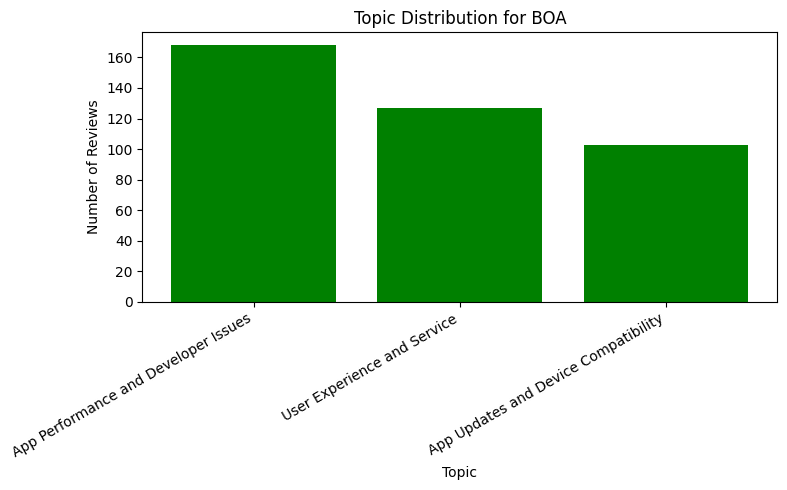


🔹 Processing Dashen...
Number of reviews: 380

🔹 Topic 0:
['good', 'amazing', 'feature', 'nice', 'need', 'account', 'slow', 'option', 'new', 'like']

🔹 Topic 1:
['banking', 'best', 'super', 'feature', 'step', 'user', 'experience', 'mobile', 'fast', 'make']

🔹 Topic 2:
['super', 'easy', 'fast', 'time', 'work', 'transaction', 'like', 'wow', 'love', 'service']


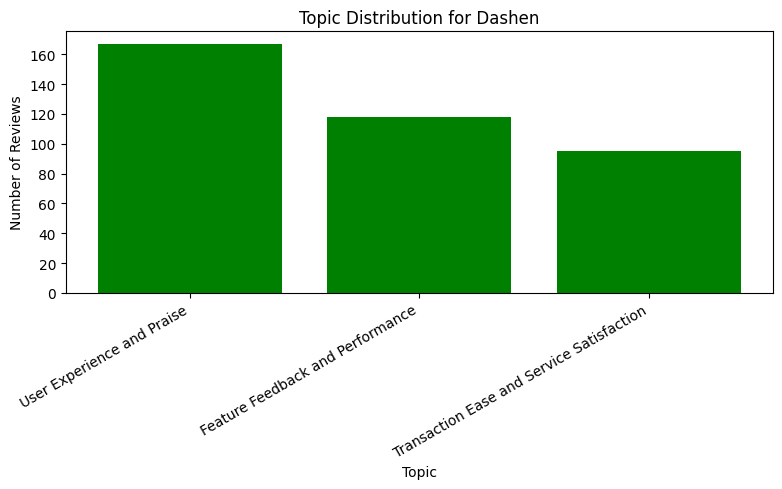


🎉 All done! Topic modeling with your custom labels complete for all banks.


In [31]:
# Thematic analysis using Topic Modelling

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


n_topics = 3

for bank in banks:
    print(f"\n========================")
    print(f"🔹 Processing {bank}...")

    #  Filter reviews for this bank
    bank_reviews = reviews[reviews['bank'] == bank]['processed_review'].dropna().tolist()
    print("Number of reviews:", len(bank_reviews))

    #  Create the document-term matrix
    vectorizer = CountVectorizer(
        stop_words=stop_words,
        max_df=0.95,
        min_df=2
    )
    dtm = vectorizer.fit_transform(bank_reviews)

    #  Fit LDA
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)

    # Show keywords with assigned topics
    
    feature_names = vectorizer.get_feature_names_out()

    n_top_words = 10

    for idx, topic in enumerate(lda.components_):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        print(f"\n🔹 Topic {idx}:")
        print(top_words)


    #  Assign dominant topic number
    topic_results = lda.transform(dtm)
    bank_topic_nums = topic_results.argmax(axis=1)

    #  Create an intermediate DataFrame for this bank
    bank_df = reviews[reviews['bank'] == bank].dropna(subset=['processed_review']).copy()
    bank_df['topic_num'] = bank_topic_nums



    #  Manually assign topic labels for extracted topic numbers

    if bank == 'CBE':
        topic_labels = {
            0: 'Transaction Experience',
            1: 'App and Service Feedback',
            2: 'Performance and Reliability'
        }
    elif bank == 'BOA':
        topic_labels = {
            0: 'App Performance and Developer Issues',
            1: 'User Experience and Service',
            2: 'App Updates and Device Compatibility'
        }
    elif bank == 'Dashen':
        topic_labels = {
            0: 'Feature Feedback and Performance',
            1: 'User Experience and Praise',
            2: 'Transaction Ease and Service Satisfaction'
        }

    else:
        topic_labels = {i: f"Topic {i}" for i in range(n_topics)}

    #  Map numeric topics to descriptive labels
    bank_df['topic_label'] = bank_df['topic_num'].map(topic_labels)

    #  Assign topic labels to original data

    reviews.loc[bank_df.index, 'topic_label'] = bank_df['topic_label']
    
    # Plot topic distribution for each
    
    plt.figure(figsize=(8,5))
    topic_counts = bank_df['topic_label'].value_counts()
    plt.bar(topic_counts.index, topic_counts.values, color='green')
    plt.xlabel('Topic')
    plt.ylabel('Number of Reviews')
    plt.title(f'Topic Distribution for {bank}')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

print("\n🎉 All done! Topic modeling with your custom labels complete for all banks.")

#  Assign topic labels to original data

reviews.loc[bank_df.index, 'topic_label'] = bank_df['topic_label']

In [ ]:
# Save new data to csv file
reviews.to_csv('../data/analyzed_review.csv', index=False)

In [ ]:
# Load analyzed reviews data
import pandas as pd

new_df = pd.read_csv('../data/analyzed_review.csv', parse_dates=['date'])

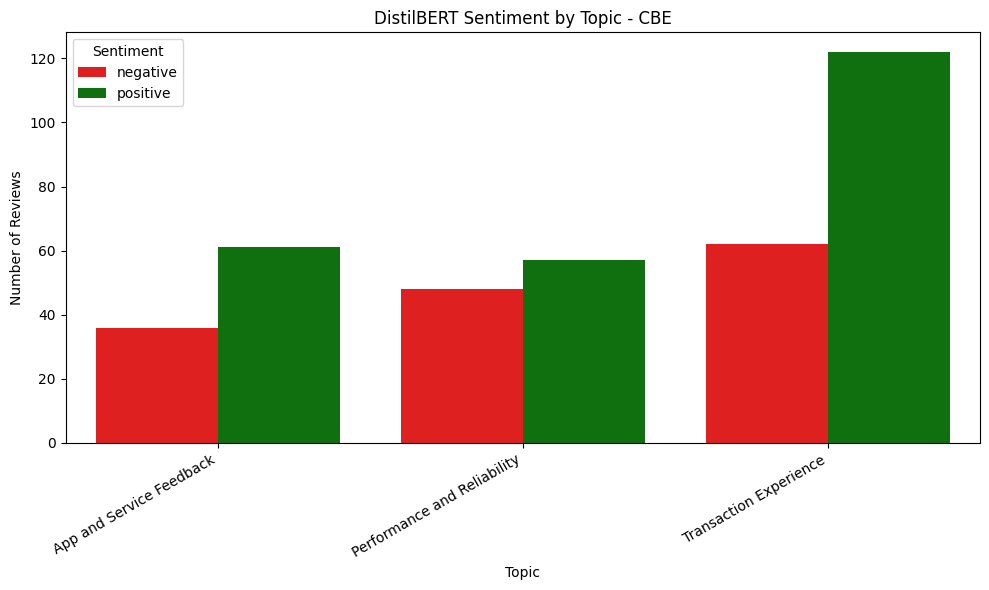

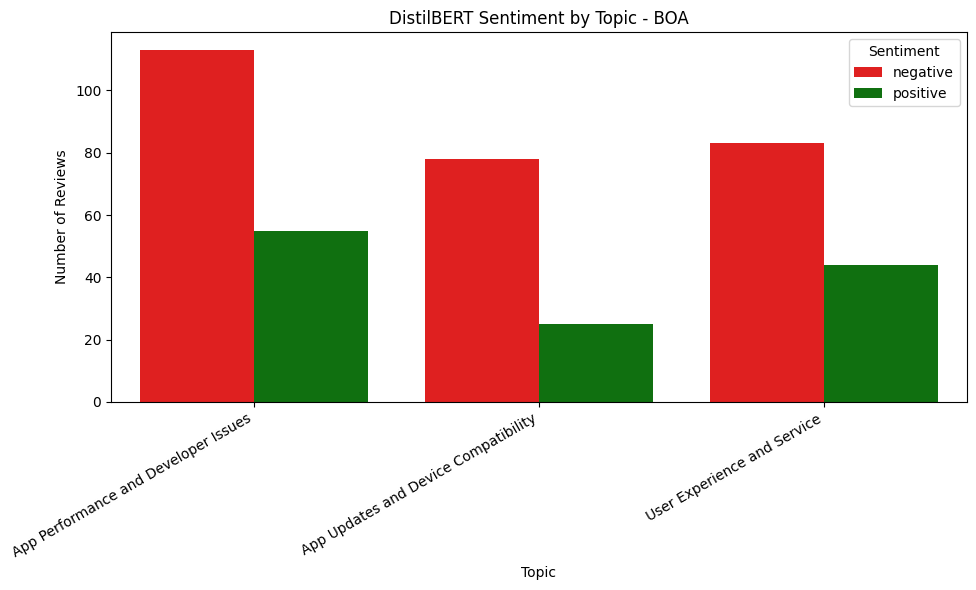

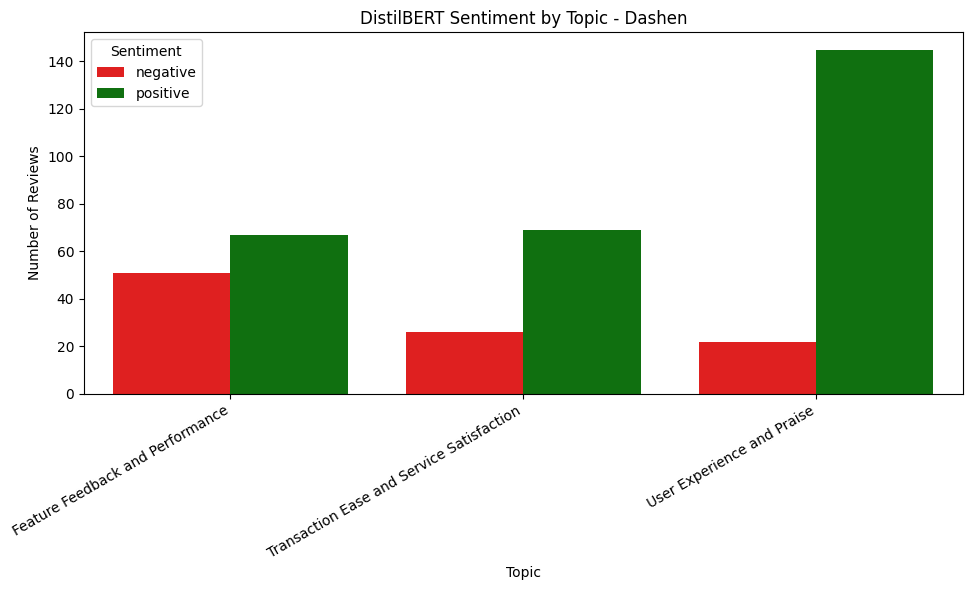

In [ ]:
# Theme analysis for positive and negative reviews for each bank

import seaborn as sns
import matplotlib.pyplot as plt

#  Filter and group counts by sentiment, topic, and bank
sentiment_counts = new_df[new_df['distilBert_sentiment'].isin(['positive', 'negative'])] \
    .groupby(['bank', 'topic_label', 'distilBert_sentiment']) \
    .size() \
    .reset_index(name='count')

#  Step 2: Plot grouped bar chart for each bank
for bank in new_df['bank'].unique():
    bank_data = sentiment_counts[sentiment_counts['bank'] == bank]

    plt.figure(figsize=(10,6))
    sns.barplot(
        data=bank_data,
        x='topic_label',
        y='count',
        hue='distilBert_sentiment',
        palette={'positive': 'green', 'negative': 'red'}
    )

    plt.title(f'DistilBERT Sentiment by Topic - {bank}')
    plt.xlabel('Topic')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.savefig(f"{bank.lower()}_bert_sentiment_by_topic.png")
    plt.show()


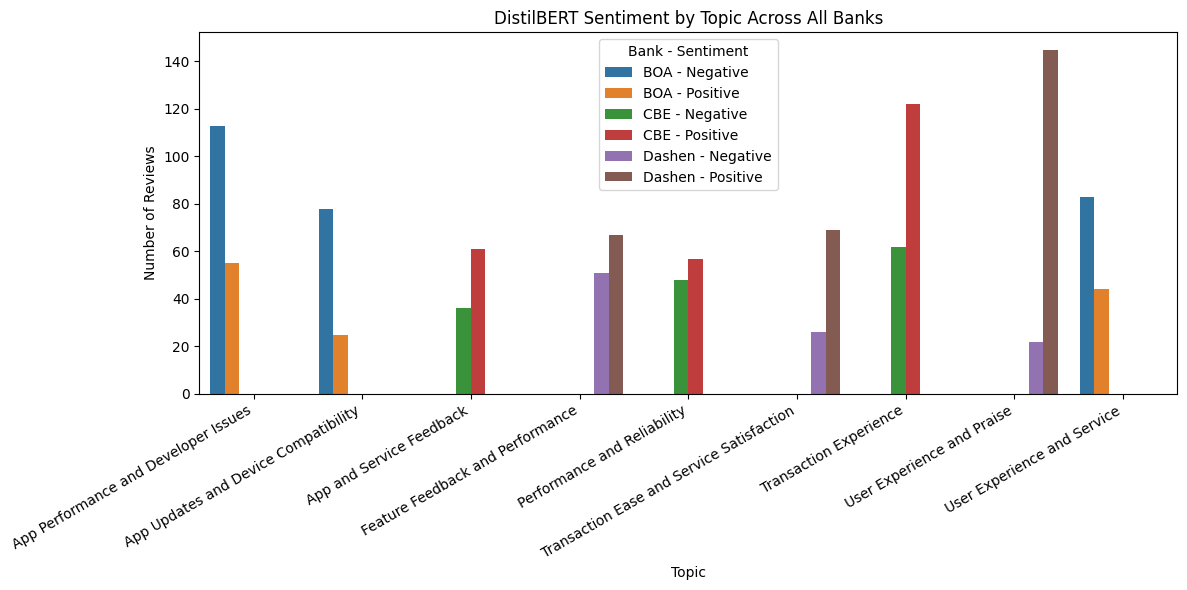

In [ ]:
# Comparison using One Chart for All Banks

import seaborn as sns
import matplotlib.pyplot as plt

#  Filter to positive and negative reviews
filtered_df = new_df[new_df['distilBert_sentiment'].isin(['positive', 'negative'])].copy()

#  Create a new column combining bank and sentiment
filtered_df['bank_sentiment'] = filtered_df['bank'] + ' - ' + filtered_df['distilBert_sentiment'].str.capitalize()

#  Group by topic_label and bank_sentiment
grouped = filtered_df.groupby(['topic_label', 'bank_sentiment']).size().reset_index(name='count')

#  Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped,
    x='topic_label',
    y='count',
    hue='bank_sentiment'
)

plt.title('DistilBERT Sentiment by Topic Across All Banks')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=30, ha='right')
plt.legend(title='Bank - Sentiment')
plt.tight_layout()
plt.savefig("all_banks_sentiment_by_topic.png")
plt.show()
